In [18]:
from google.colab import drive
drive.mount('/content/drive')

# Base folder path
data_folder = '/content/drive/My Drive/Colab Notebooks/MARG/Deep Realbook/data/'
utils_folder = '/content/drive/My Drive/Colab Notebooks/MARG/Deep Realbook/utils/'

import sys
sys.path.append(utils_folder)

import importlib
import utils, config

importlib.reload(utils)  # Reload the module after making changes
importlib.reload(config)  # Reload the module after making changes

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<module 'config' from '/content/drive/My Drive/Colab Notebooks/MARG/Deep Realbook/utils/config.py'>

In [2]:
import json

with open(data_folder + 'mapped_results.json', 'r') as file:
    mapped_results = json.load(file)

In [10]:
def get_lexicographically_smallest_rotation2(queue):
    """Get the lexicographically smallest rotation of the queue and the rotation index."""
    n = len(queue)
    rotations = [queue[i:] + queue[:i] for i in range(n)]
    min_rotation = min(rotations)
    rotation_index = rotations.index(min_rotation)
    return min_rotation, rotation_index

In [19]:
from config import note_to_index, index_to_note

def transpose_chord(chord, rotation):
    if chord in ['NC', '|']:  # No transposition for 'NC' or bar token
        return chord

    # Split the chord into root and tension (if any)
    root = chord[0]
    tension = ''
    if len(chord) > 1 and chord[1] in ['#', 'b']:
        root += chord[1]
        tension = chord[2:]
    elif len(chord) > 1:
        tension = chord[1:]

    root_index = note_to_index.get(root, None)
    if root_index is None:
        return chord  # Return the chord as is if root is not found

    transposed_root_index = (root_index - rotation) % 12
    transposed_root = index_to_note[transposed_root_index]
    return transposed_root + tension


In [9]:
from config import tension_intervals_reduced
from itertools import product

# Define the roots and tensions
first_root = 'C'
other_roots = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']
tensions = list(tension_intervals_reduced.keys())

# Generate all combinations for chord-to-chord mapping with first root as 'C'
chord_to_chord_pairs = [(first_root + tension1, root2 + tension2) for tension1, root2, tension2 in product(tensions, other_roots, tensions)]

# Generate pairs involving 'NC', using 'C' as the root
nc_pairs = [(first_root + tension, 'NC') for tension in tensions] + \
           [('NC', first_root + tension) for tension in tensions] + \
           [('NC', 'NC')]

# Combine both sets of pairs
all_chord_pairs = chord_to_chord_pairs + nc_pairs

In [20]:
from utils import chord_to_vector, map_vectors_to_categories

# Process each chord pair
mapped_results = []
for first_chord, next_chord in all_chord_pairs:
    vector1 = chord_to_vector(first_chord)
    vector2 = chord_to_vector(next_chord)
    categories = map_vectors_to_categories(vector1, vector2)
    smallest_rotation, rotation_index = get_lexicographically_smallest_rotation2(categories)

    # Transpose the original chord pairs based on the rotation index
    transposed_first_chord = transpose_chord(first_chord, rotation_index)
    transposed_next_chord = transpose_chord(next_chord, rotation_index)

    mapped_results.append((first_chord, next_chord, smallest_rotation, (transposed_first_chord, transposed_next_chord)))

# Print some examples from the results
print("First few mapped results:")
for example in mapped_results[:5]:
    print(example)


First few mapped results:
('C', 'C', ['A', 'A', 'A', 'A', 'D', 'A', 'A', 'A', 'D', 'A', 'A', 'D'], ('E', 'E'))
('C', 'C7#11', ['A', 'A', 'A', 'D', 'A', 'C', 'D', 'A', 'A', 'C', 'A', 'D'], ('B', 'B7#11'))
('C', 'C-7', ['A', 'A', 'C', 'A', 'D', 'A', 'A', 'C', 'B', 'A', 'A', 'D'], ('E', 'E-7'))
('C', 'C13#9', ['A', 'A', 'C', 'D', 'A', 'A', 'D', 'A', 'C', 'C', 'A', 'D'], ('B', 'B13#9'))
('C', 'C69', ['A', 'A', 'D', 'A', 'C', 'A', 'A', 'D', 'A', 'C', 'A', 'D'], ('G', 'G69'))


In [21]:
from config import index_to_note

def char_to_binary(char):
    """Maps a character (A, B, C, D) to its binary representation."""
    binary_map = {'A': '00', 'B': '01', 'C': '10', 'D': '11'}
    return binary_map[char]

# Update the mapped results
updated_mapped_results = {}
for first_chord, next_chord, smallest_rotation, transposed_chords in mapped_results:
    representation = ''.join(smallest_rotation)
    note_binary_mapping = {index_to_note[i]: char_to_binary(representation[i]) for i in range(12)}

    updated_mapped_results[(first_chord, next_chord)] = {
        'transposed_chords': transposed_chords,
        'representation': representation,
        'note_binary_mapping': note_binary_mapping
    }

# Print some examples from the results
for key, value in list(updated_mapped_results.items())[:5]:
    print(f"Chord Pair: {key}, Transposed: {value['transposed_chords']}, Representation: {value['representation']}, Note-Binary Mapping: {value['note_binary_mapping']}")


Chord Pair: ('C', 'C'), Transposed: ('E', 'E'), Representation: AAAADAAADAAD, Note-Binary Mapping: {'C': '00', 'Db': '00', 'D': '00', 'Eb': '00', 'E': '11', 'F': '00', 'Gb': '00', 'G': '00', 'Ab': '11', 'A': '00', 'Bb': '00', 'B': '11'}
Chord Pair: ('C', 'C7#11'), Transposed: ('B', 'B7#11'), Representation: AAADACDAACAD, Note-Binary Mapping: {'C': '00', 'Db': '00', 'D': '00', 'Eb': '11', 'E': '00', 'F': '10', 'Gb': '11', 'G': '00', 'Ab': '00', 'A': '10', 'Bb': '00', 'B': '11'}
Chord Pair: ('C', 'C-7'), Transposed: ('E', 'E-7'), Representation: AACADAACBAAD, Note-Binary Mapping: {'C': '00', 'Db': '00', 'D': '10', 'Eb': '00', 'E': '11', 'F': '00', 'Gb': '00', 'G': '10', 'Ab': '01', 'A': '00', 'Bb': '00', 'B': '11'}
Chord Pair: ('C', 'C13#9'), Transposed: ('B', 'B13#9'), Representation: AACDAADACCAD, Note-Binary Mapping: {'C': '00', 'Db': '00', 'D': '10', 'Eb': '11', 'E': '00', 'F': '00', 'Gb': '11', 'G': '00', 'Ab': '10', 'A': '10', 'Bb': '00', 'B': '11'}
Chord Pair: ('C', 'C69'), Transp

Root Note: C, Count: 4
Root Note: Db, Count: 2409
Root Note: D, Count: 2541
Root Note: Eb, Count: 4176
Root Note: E, Count: 8180
Root Note: F, Count: 2563
Root Note: Gb, Count: 2872
Root Note: G, Count: 6425
Root Note: Ab, Count: 3631
Root Note: A, Count: 2547
Root Note: Bb, Count: 4515
Root Note: B, Count: 7828


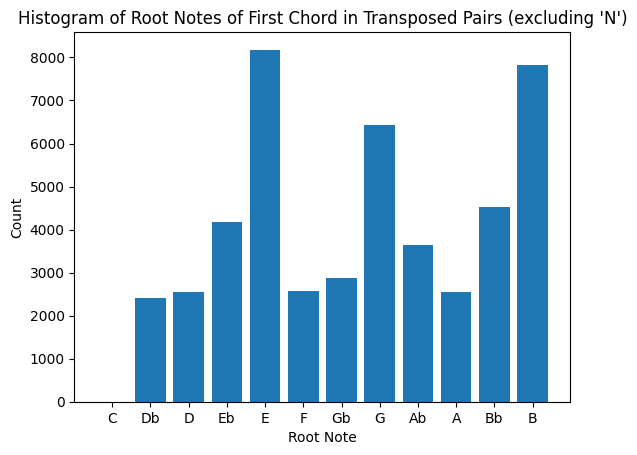

In [26]:
import matplotlib.pyplot as plt

# Define the desired order of notes
note_order = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']

# Extract the root notes of the first chord of each transposed pair
root_notes = [value['transposed_chords'][0] for value in updated_mapped_results.values()]

# Adjust extraction logic to handle flats, ignore 'N', and avoid IndexError
root_notes = [chord[:2] if len(chord) > 1 and chord[1] == 'b' else chord[0]
              for chord in root_notes if chord and chord[0] != 'N' and len(chord) > 0]

# Initialize count for all notes
root_note_counts = {note: 0 for note in note_order}

# Count the occurrences of each root note
for note in root_notes:
    if note in root_note_counts:
        root_note_counts[note] += 1

# Print count for each root note
for note, count in root_note_counts.items():
    print(f"Root Note: {note}, Count: {count}")

# Create the histogram
plt.bar(root_note_counts.keys(), root_note_counts.values())
plt.xlabel('Root Note')
plt.ylabel('Count')
plt.title('Histogram of Root Notes of First Chord in Transposed Pairs (excluding \'N\')')
plt.show()


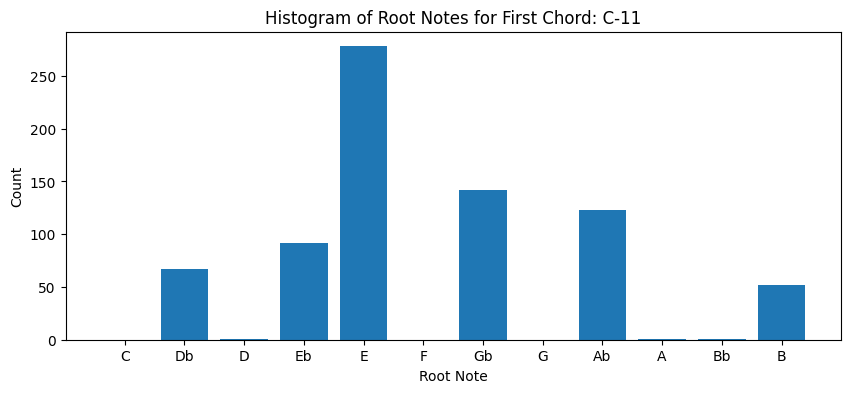

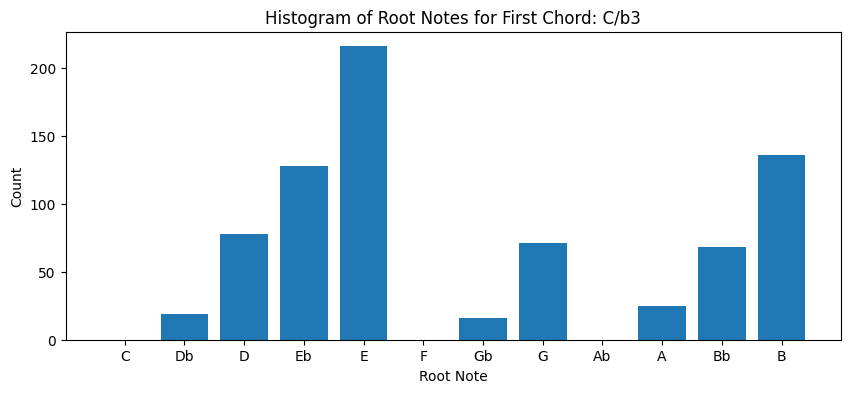

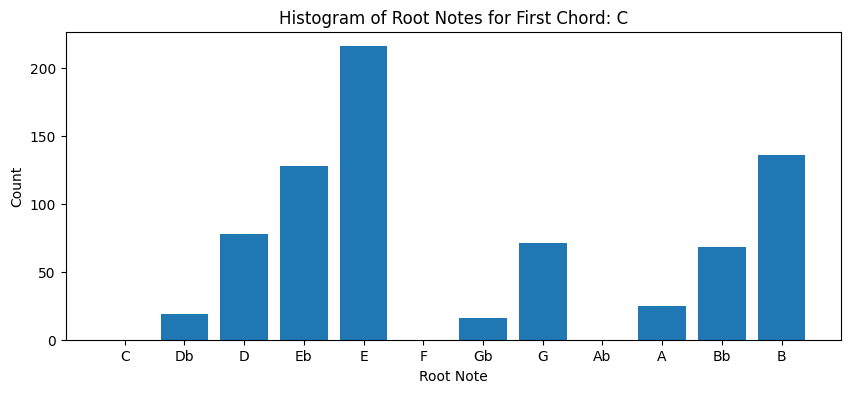

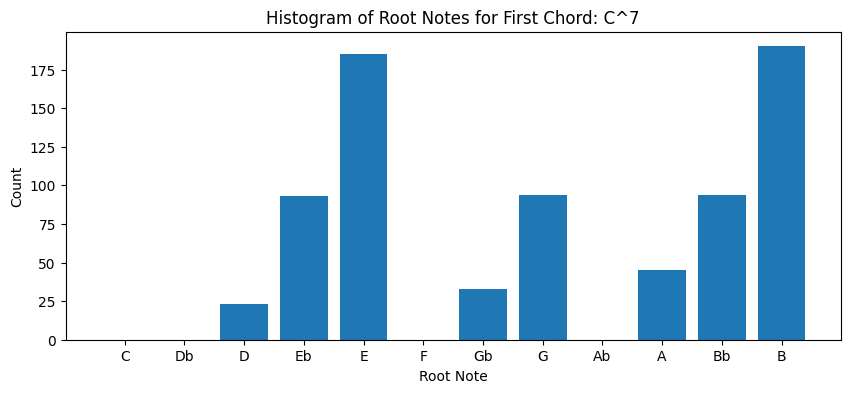

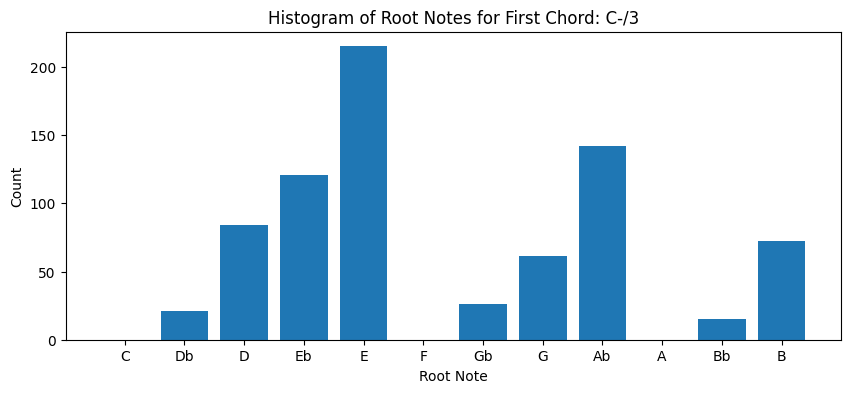

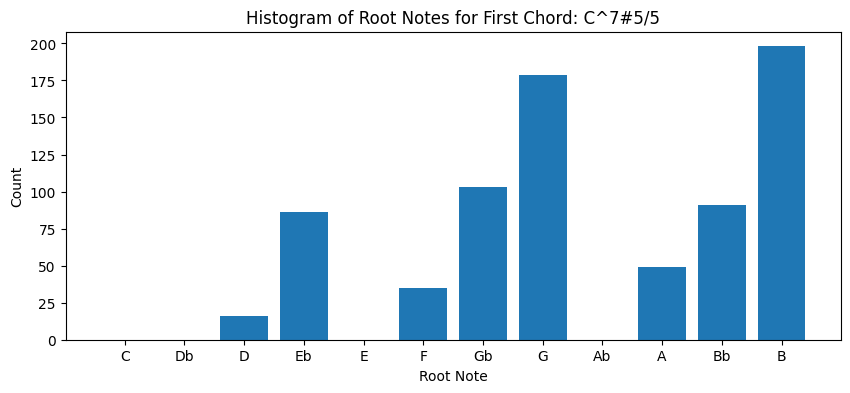

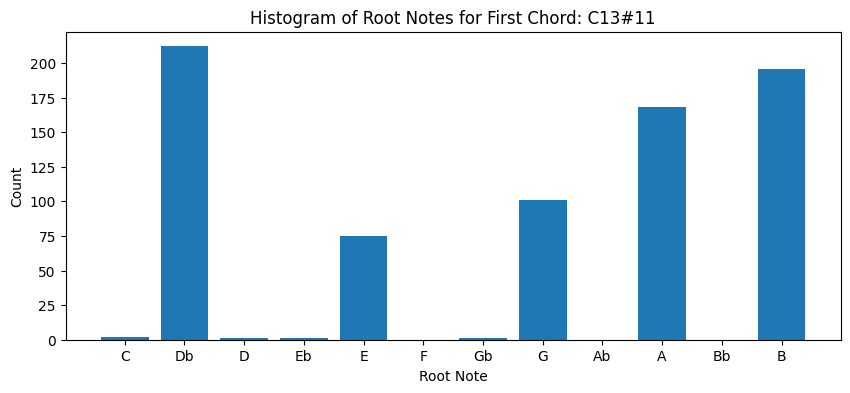

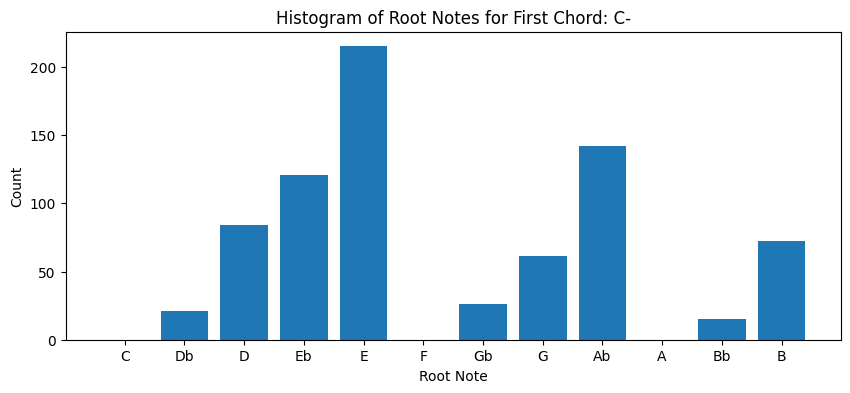

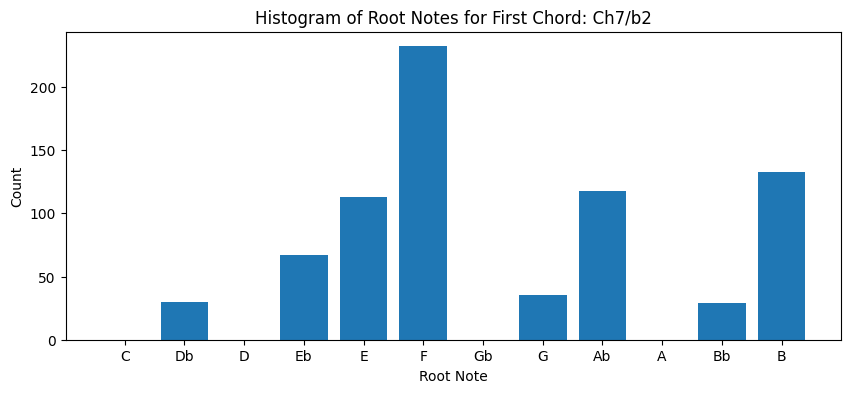

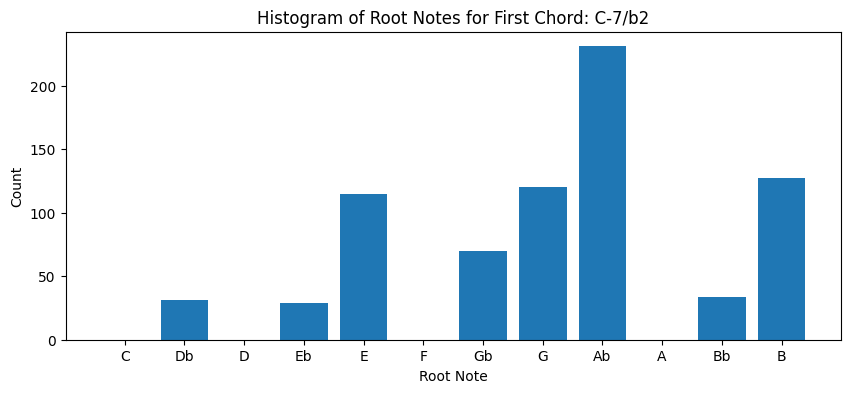

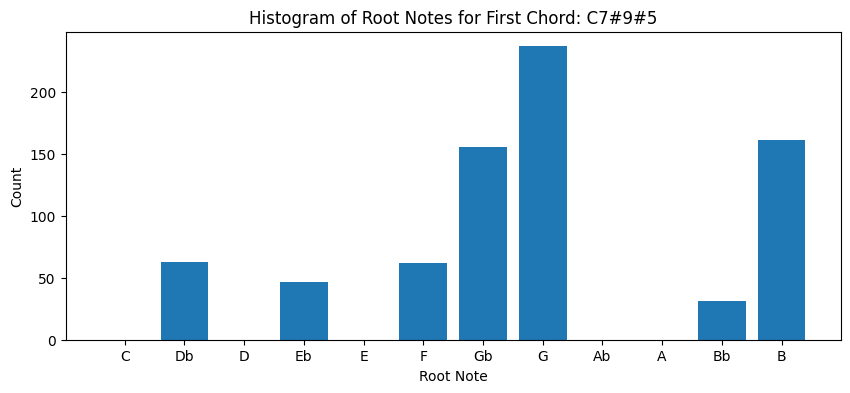

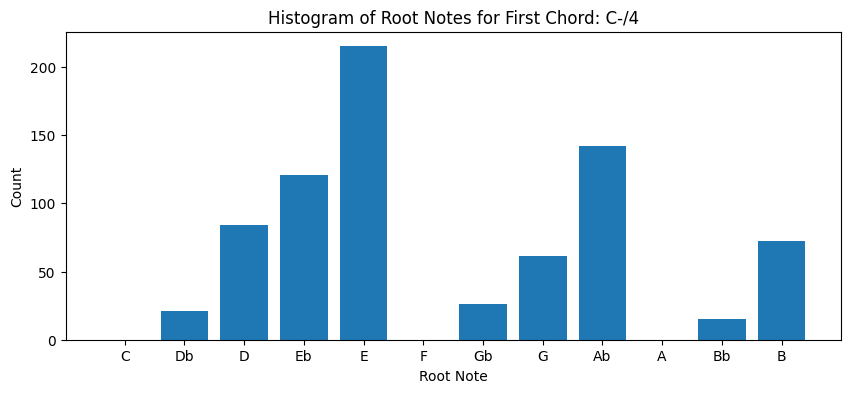

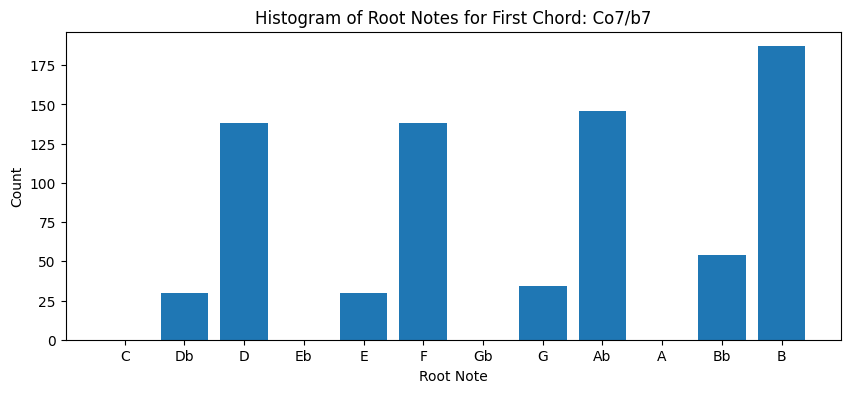

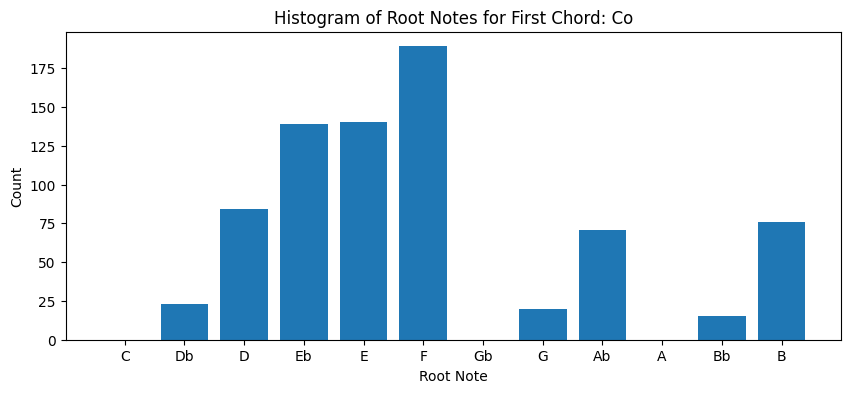

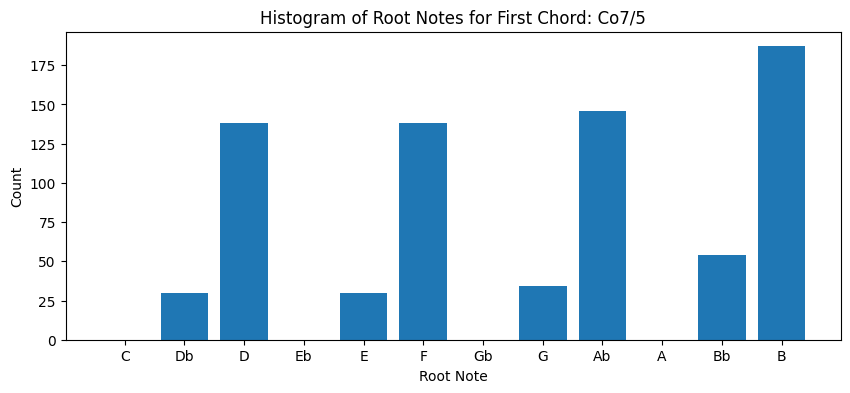

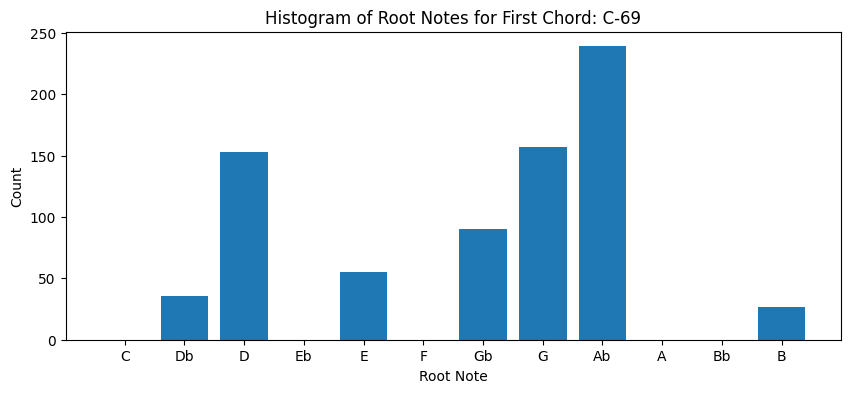

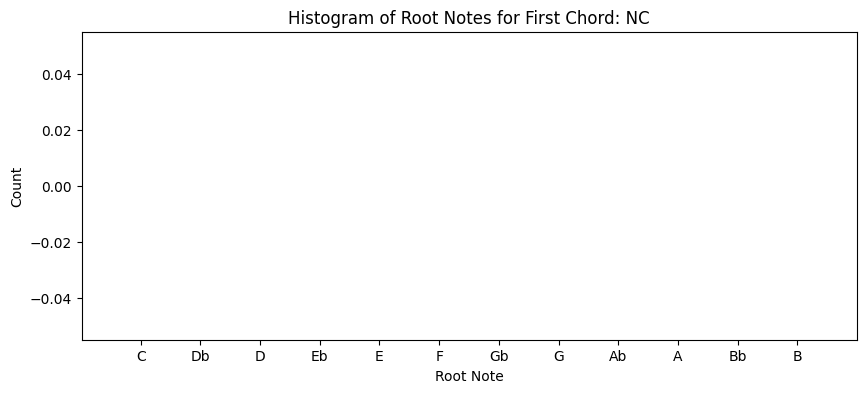

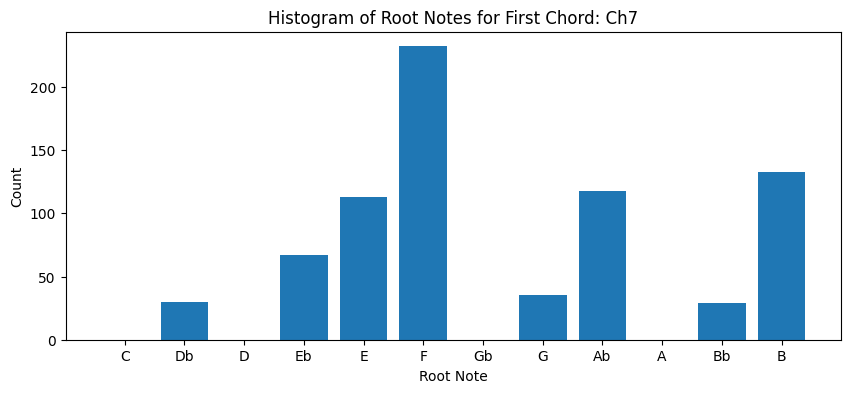

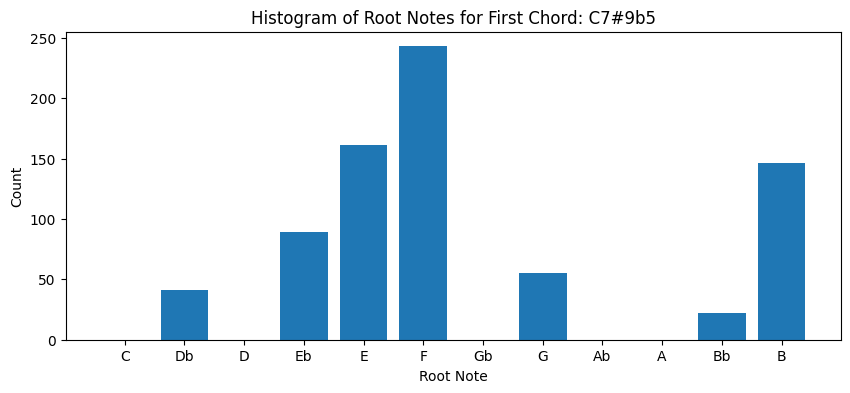

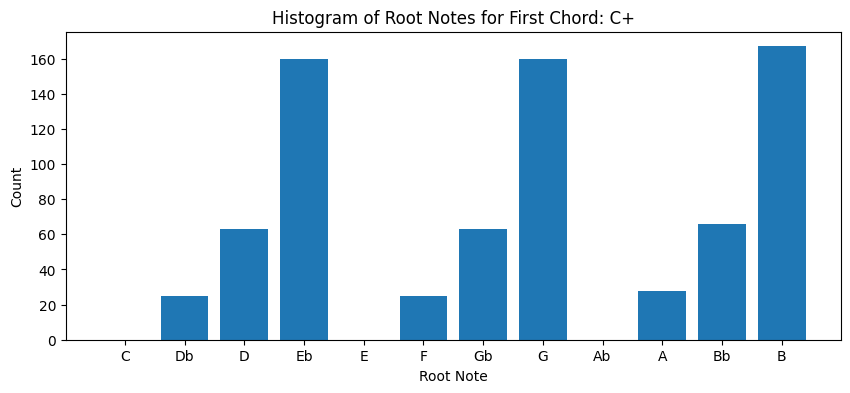

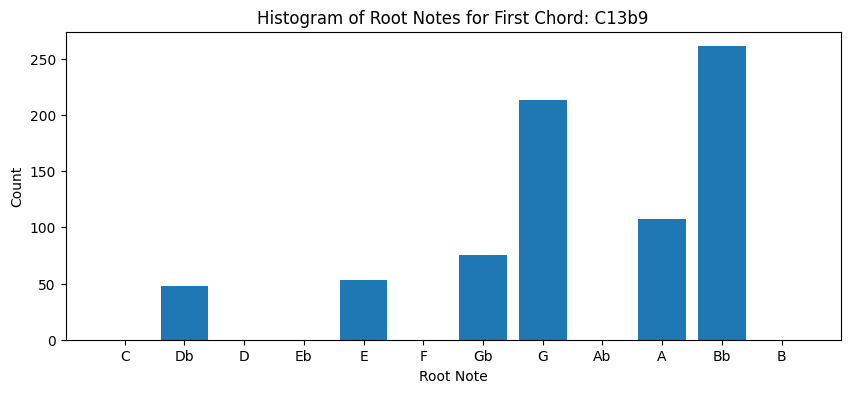

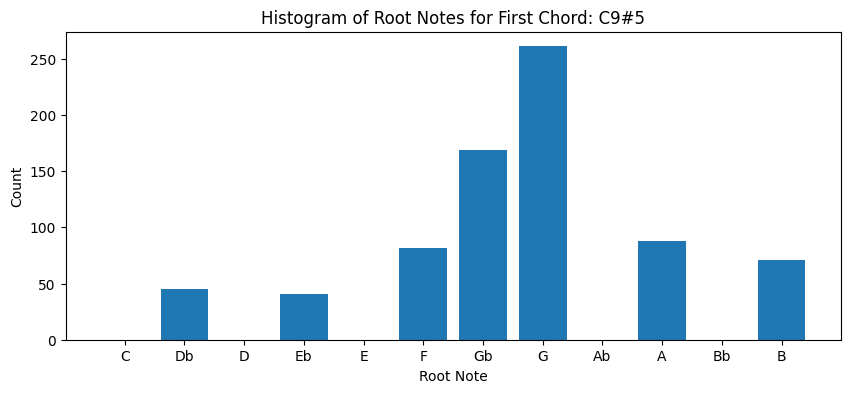

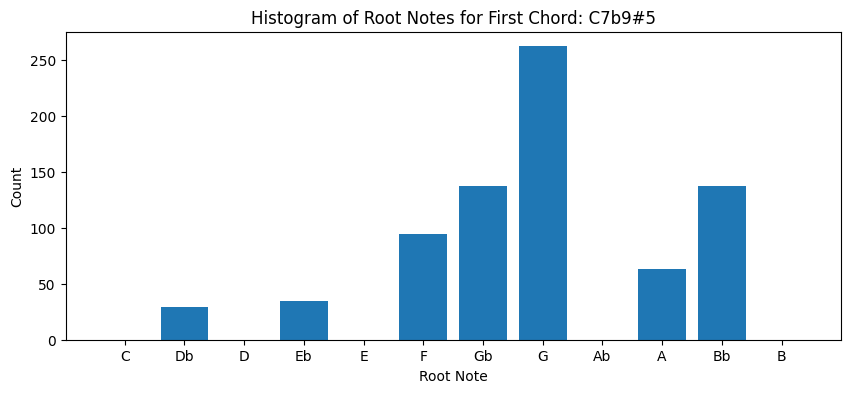

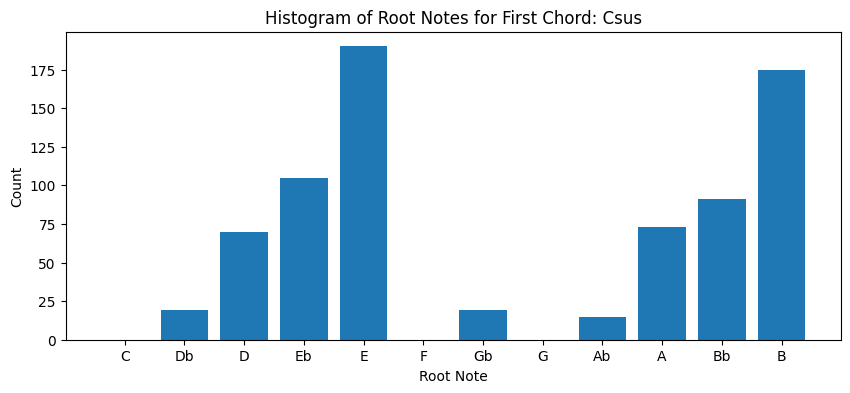

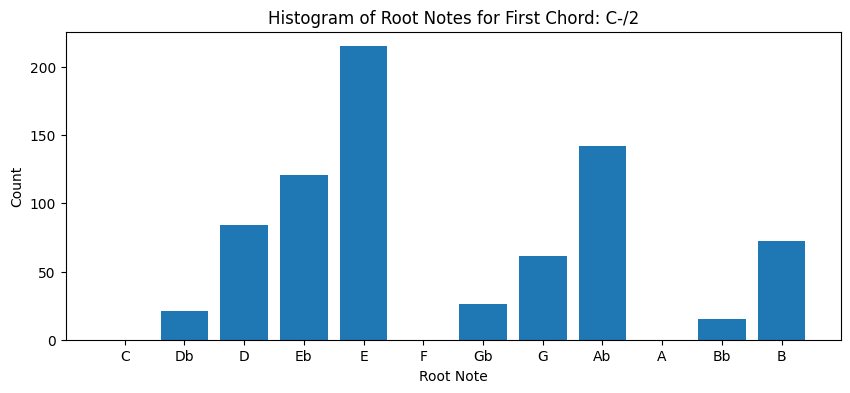

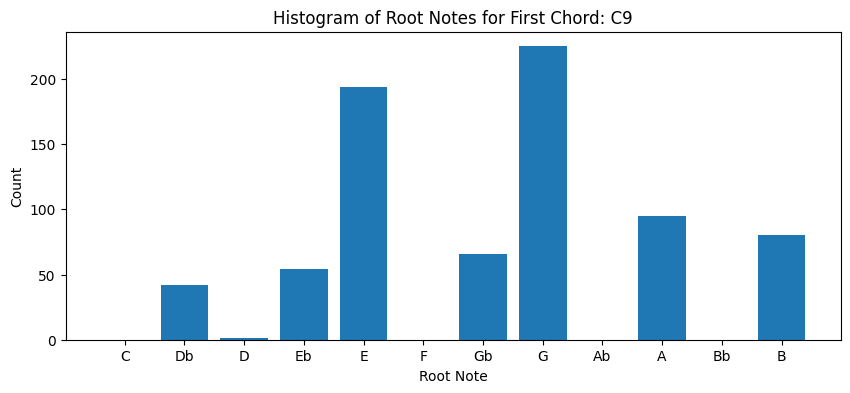

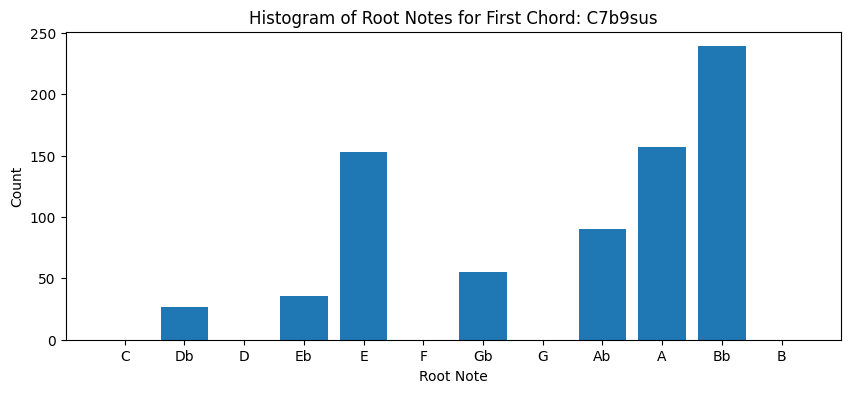

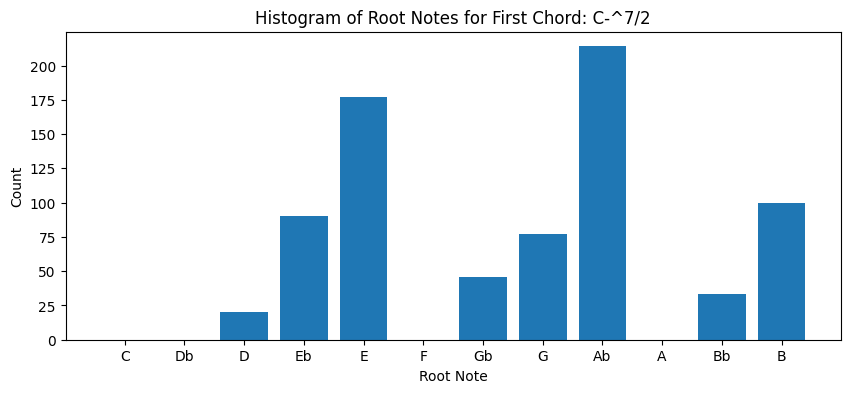

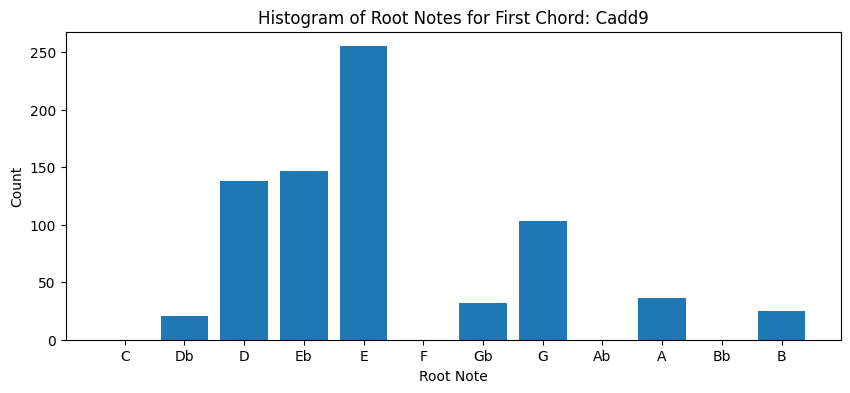

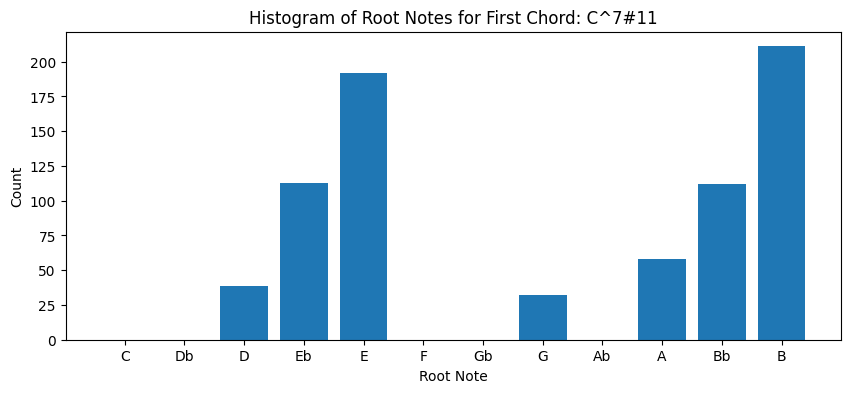

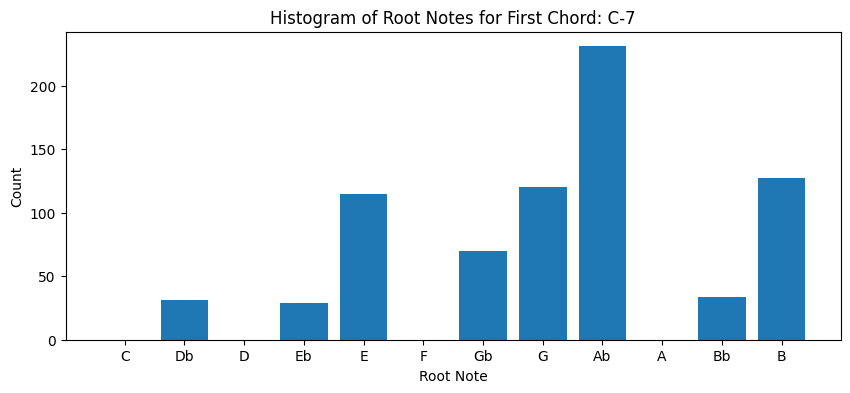

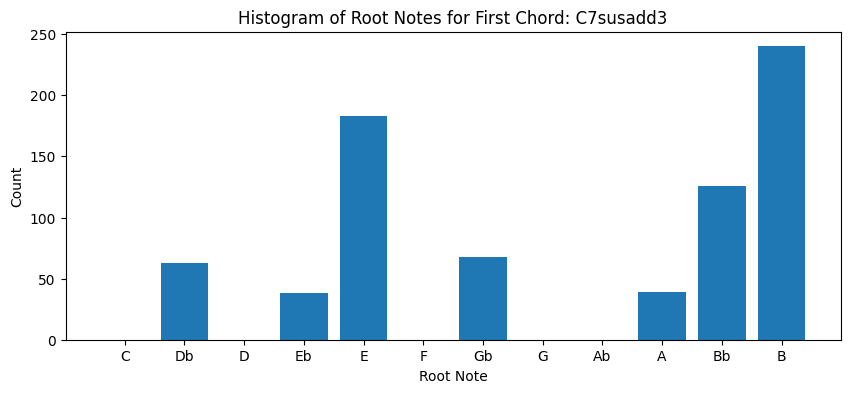

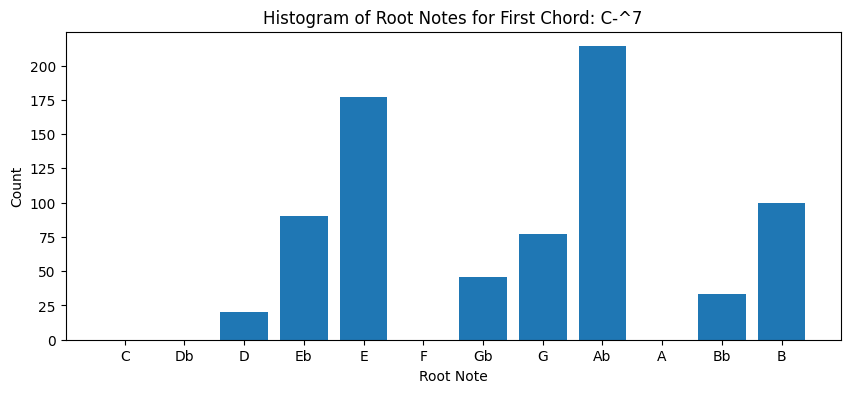

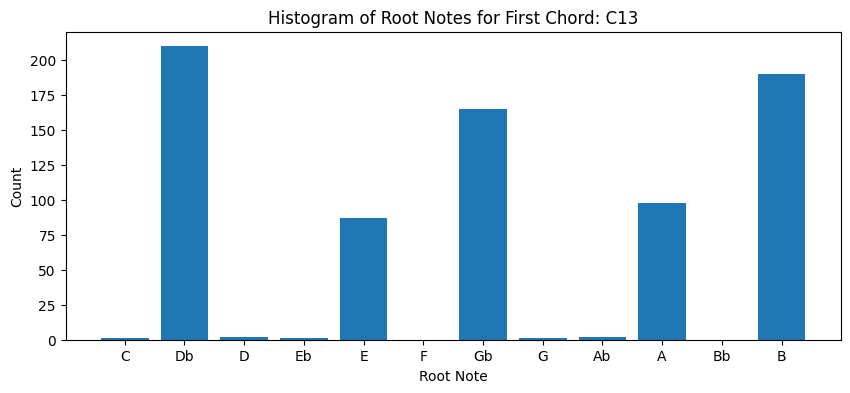

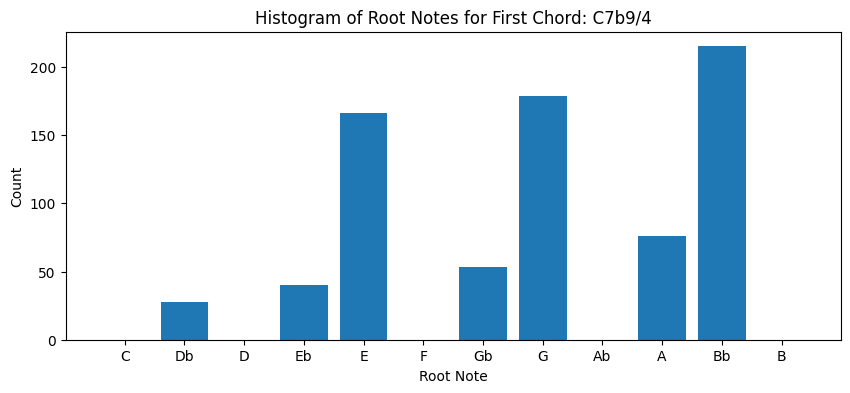

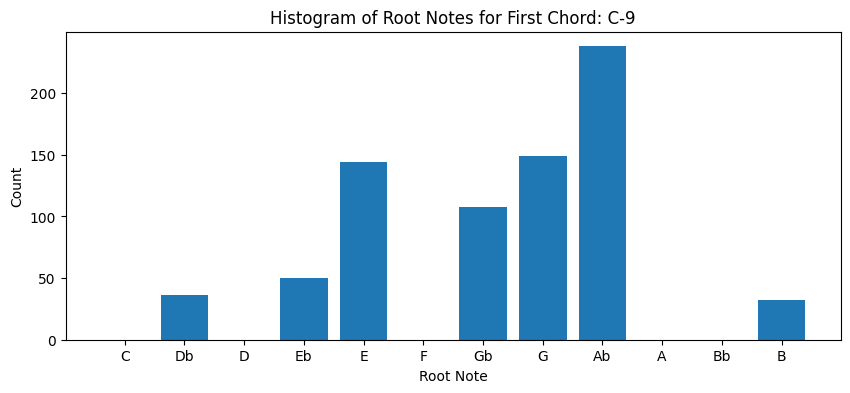

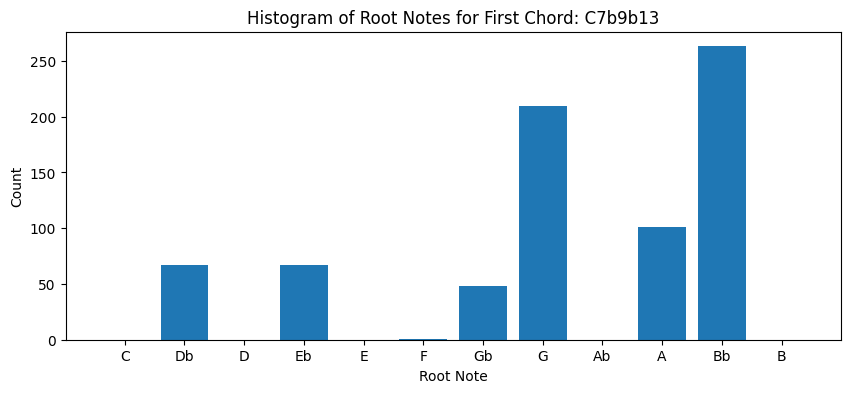

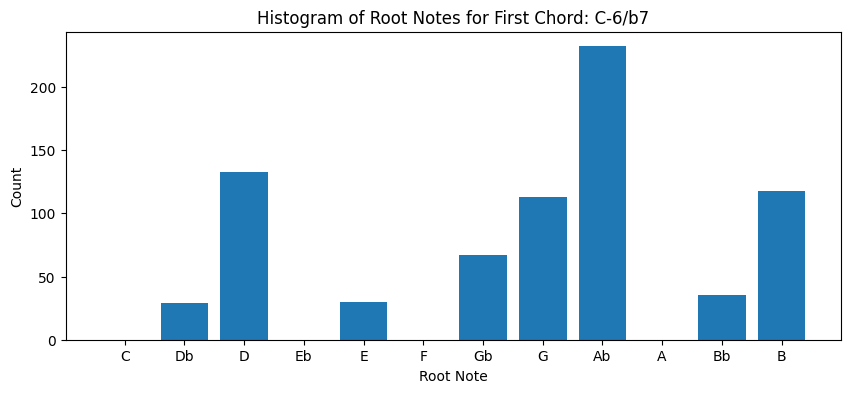

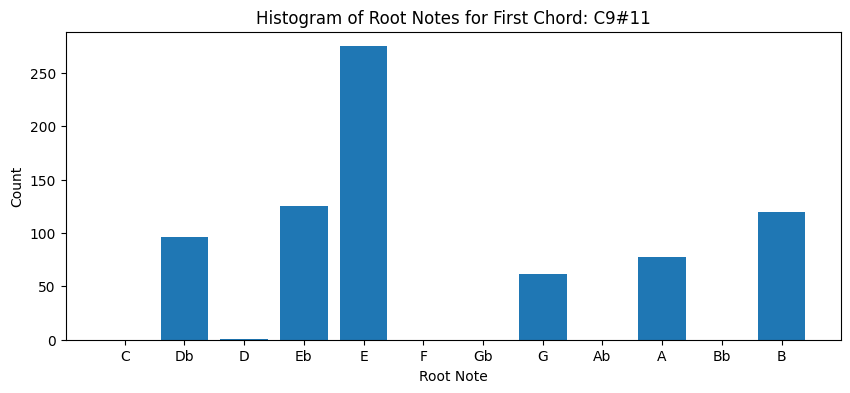

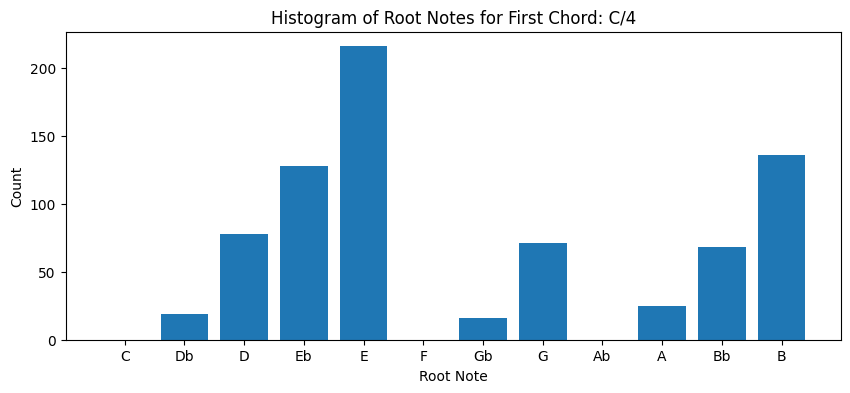

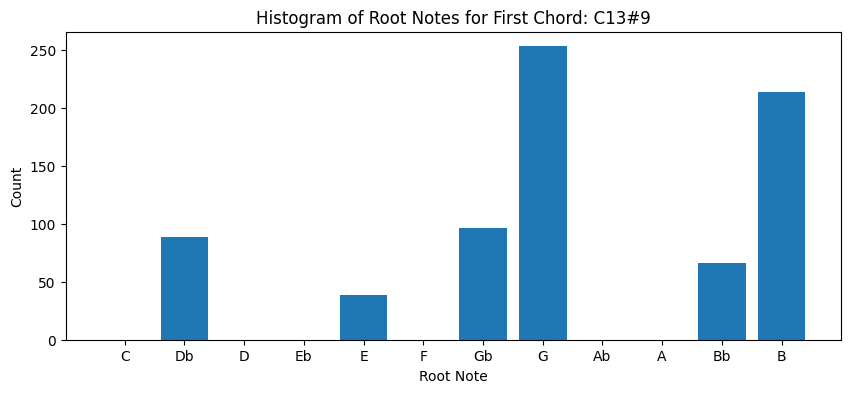

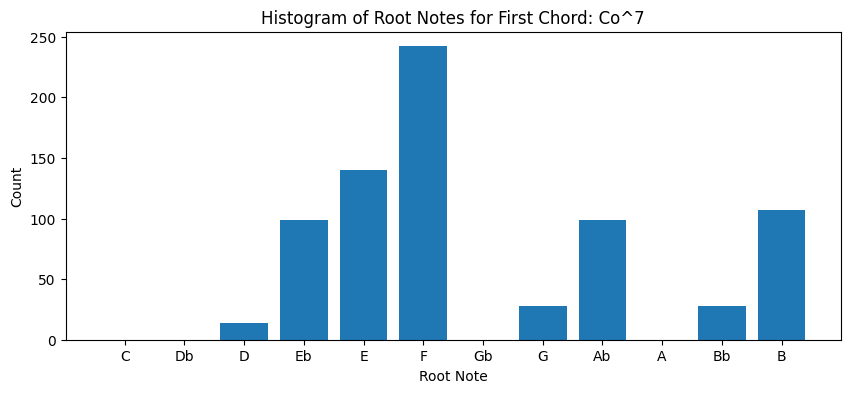

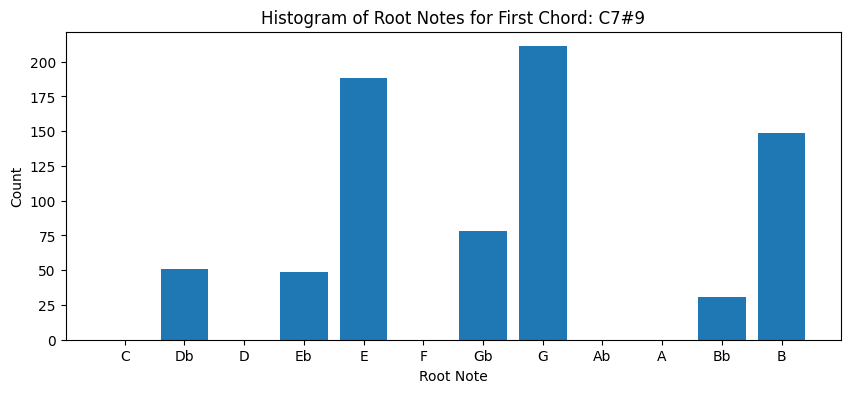

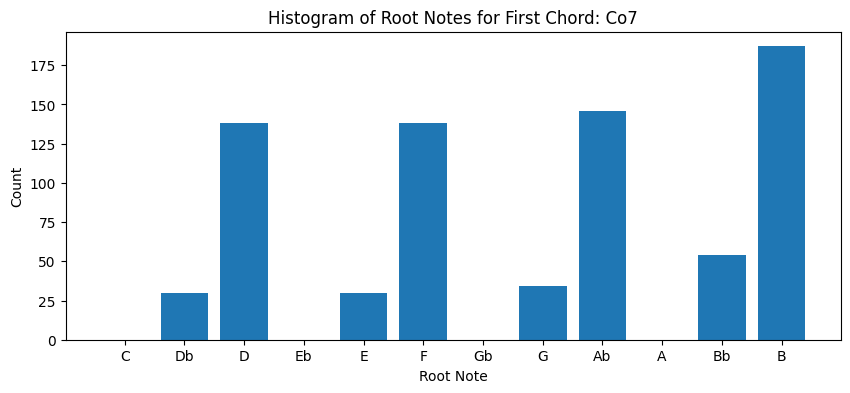

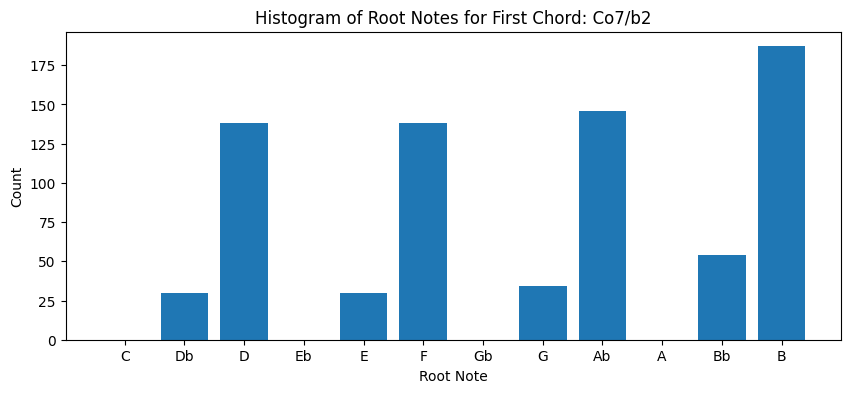

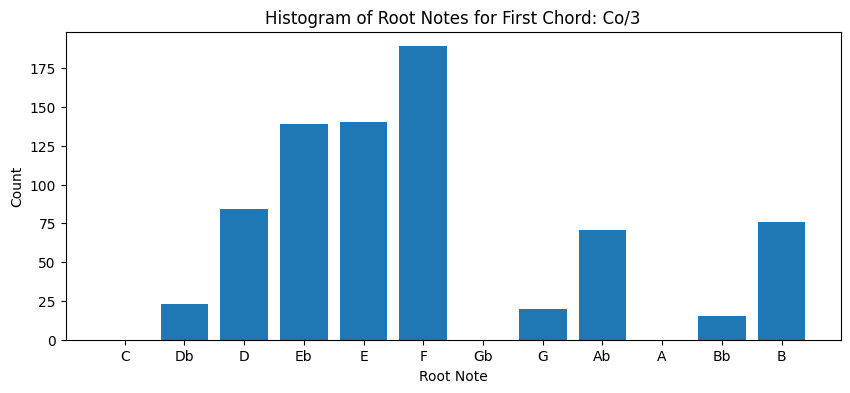

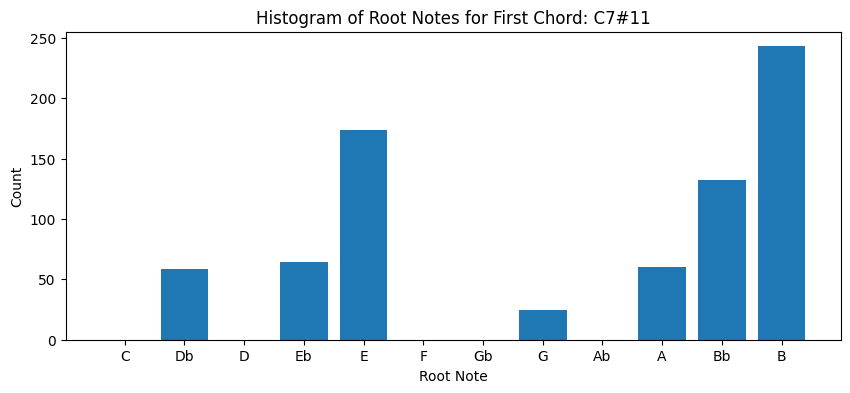

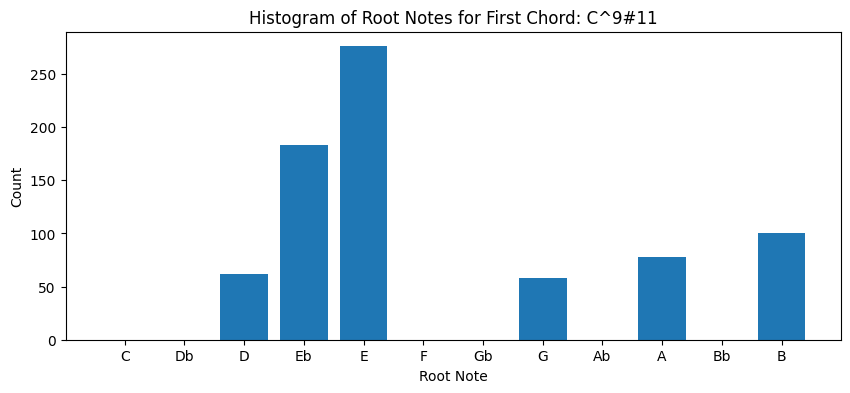

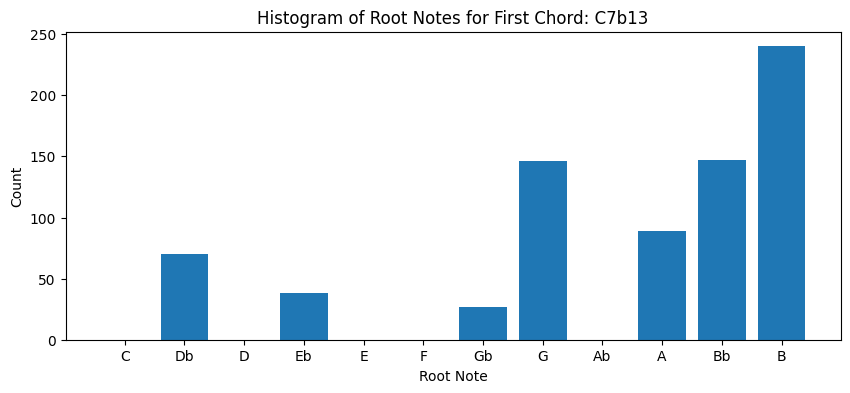

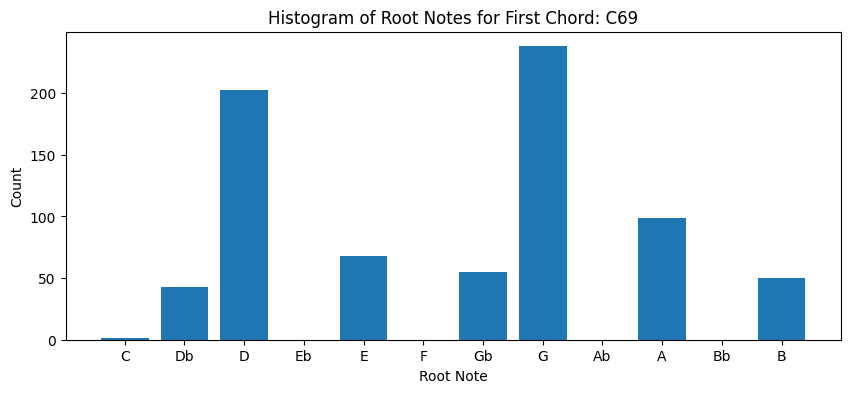

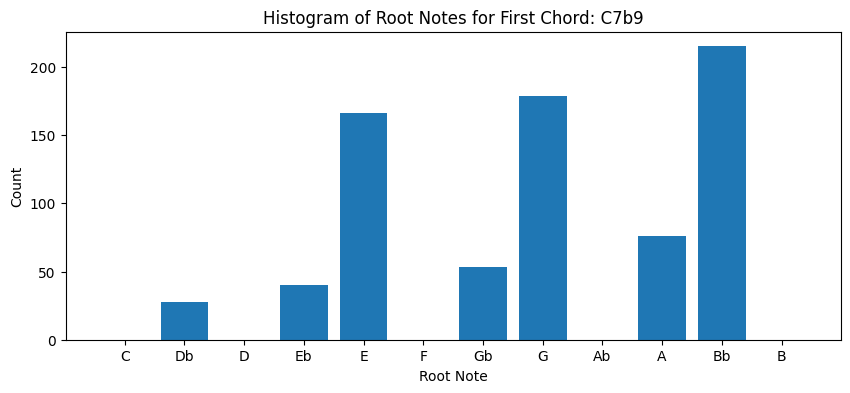

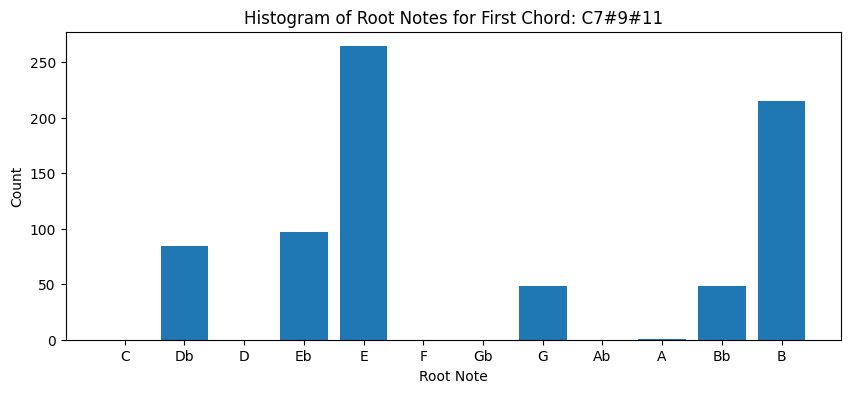

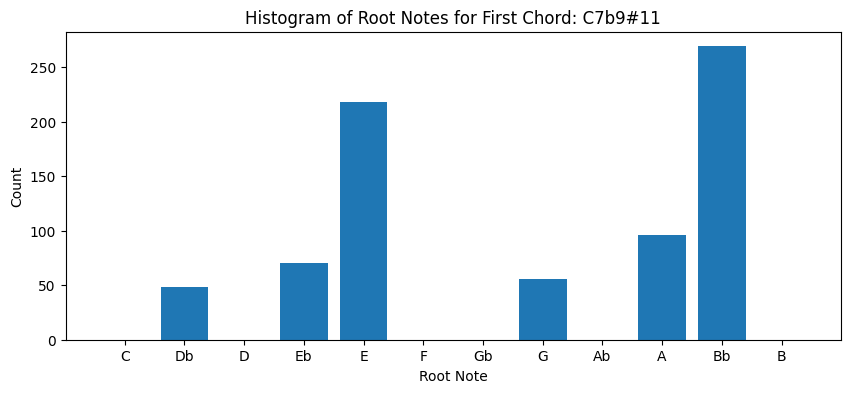

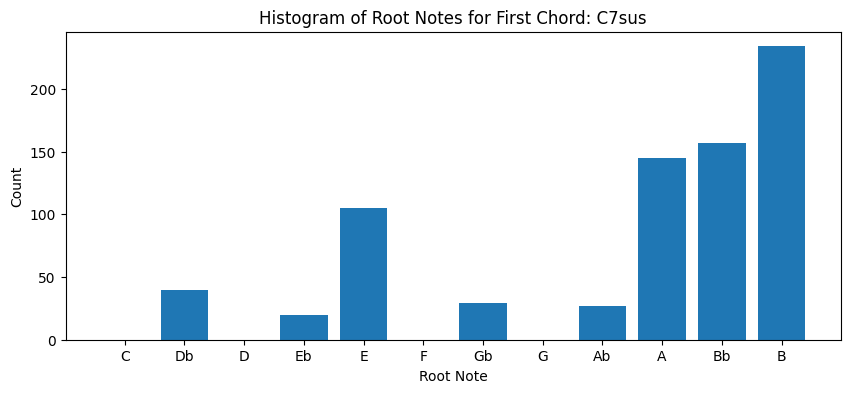

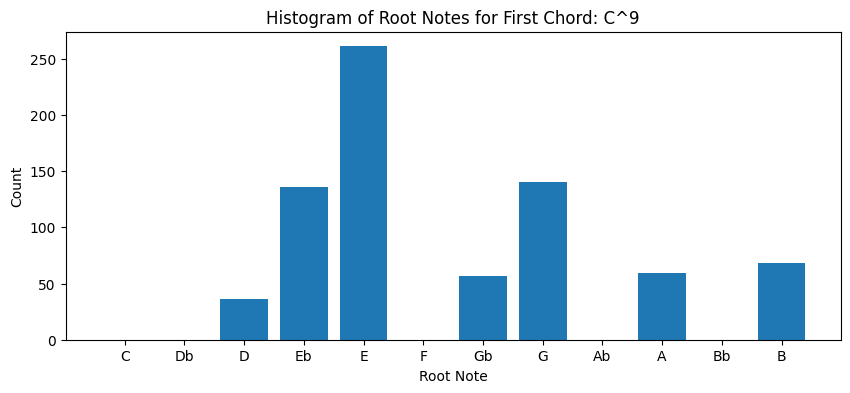

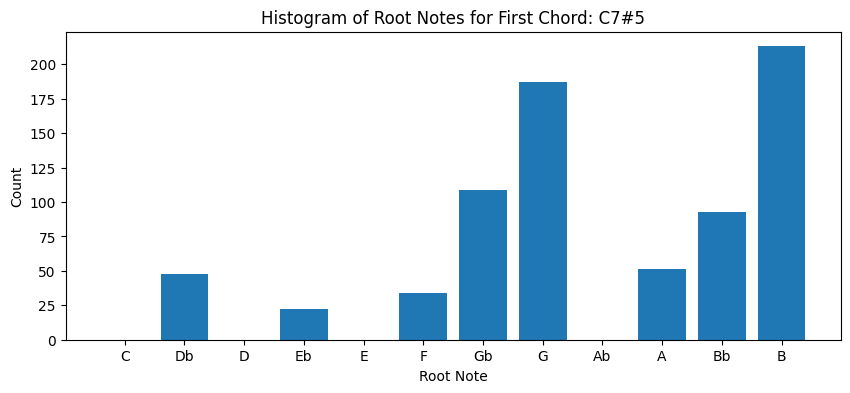

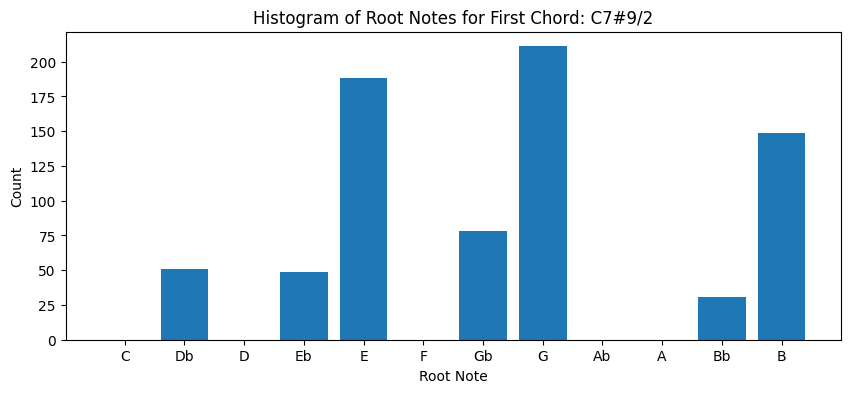

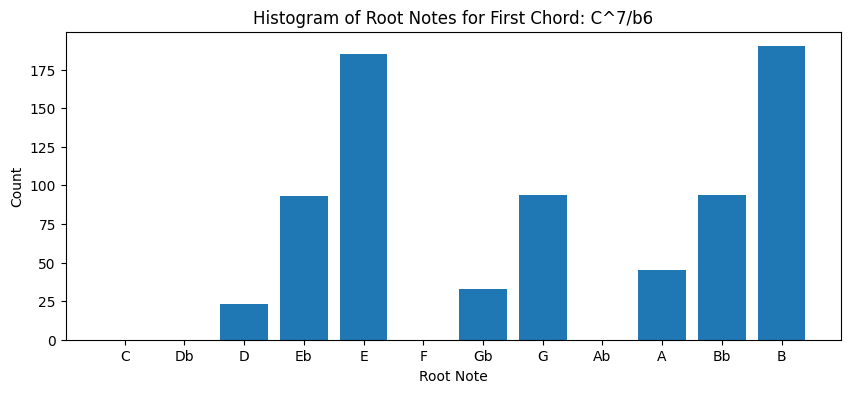

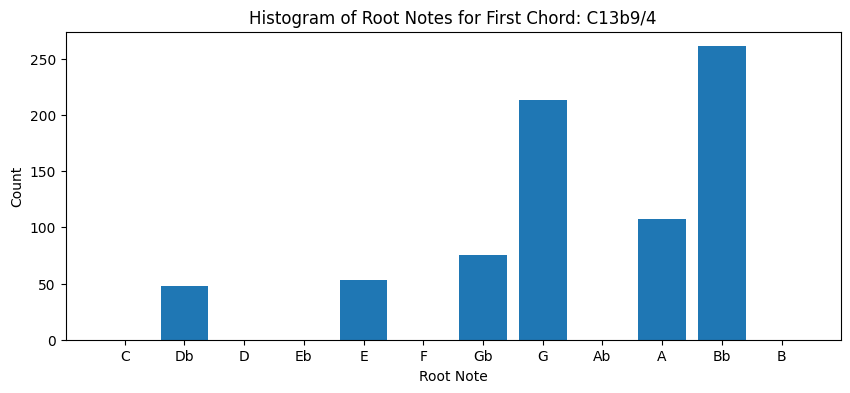

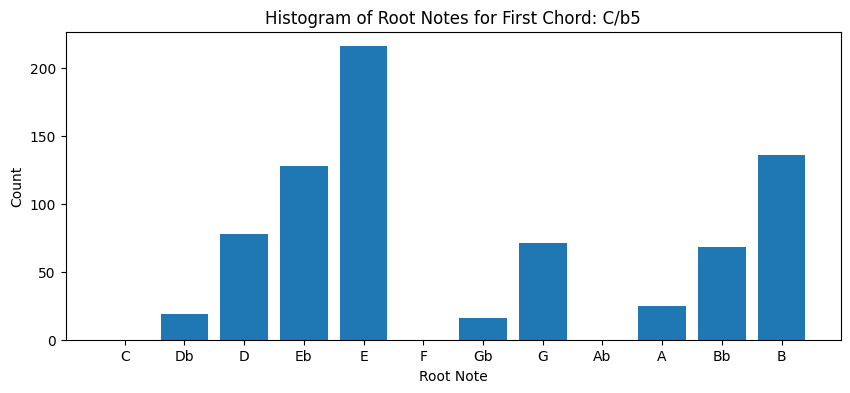

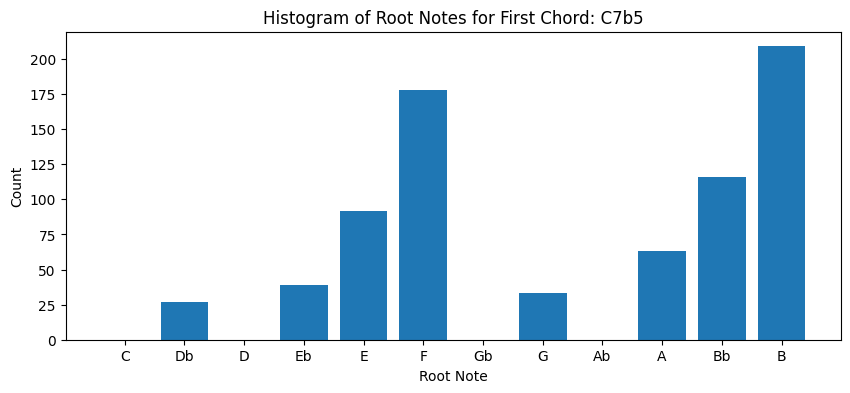

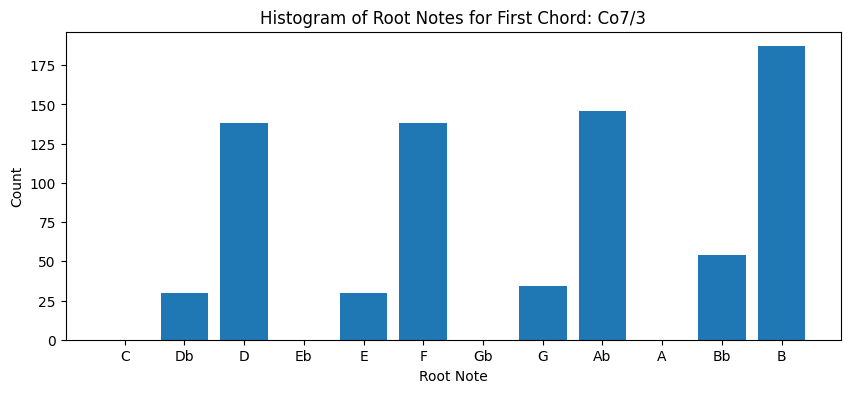

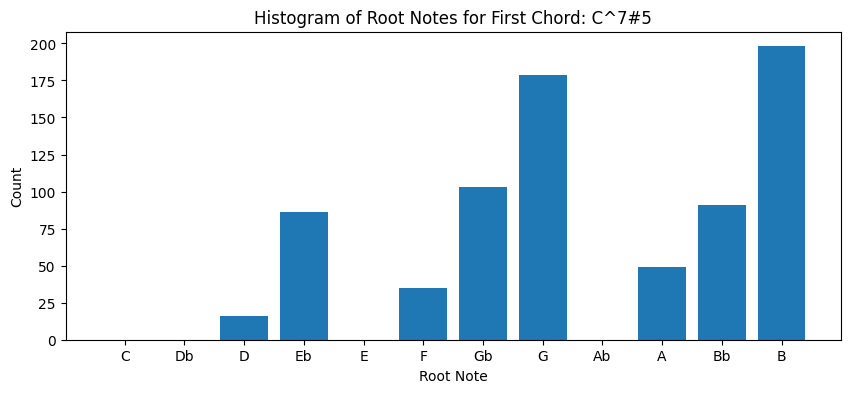

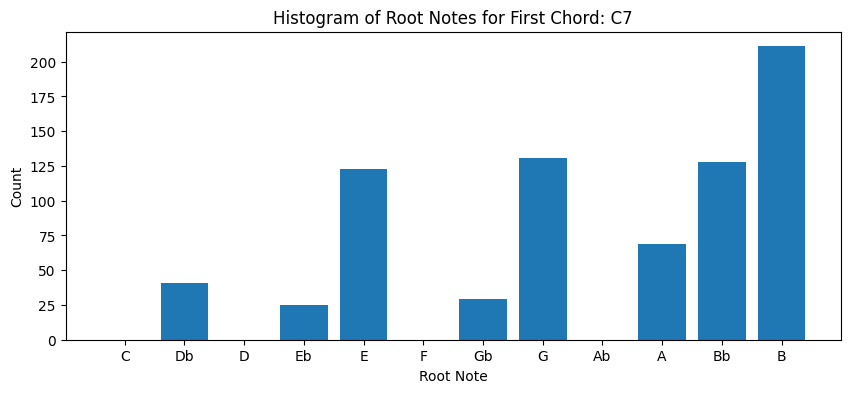

In [25]:
import matplotlib.pyplot as plt

def extract_root(note):
    """Extracts the root note, considering flats."""
    return note[:2] if len(note) > 1 and note[1] == 'b' else note[0]

# Define the desired order of notes
note_order = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']

# Find all unique first chords in the key-chord pairs
unique_first_chords = set(key[0] for key in updated_mapped_results.keys())

# Function to sort notes based on the predefined order
def sort_notes(notes):
    return sorted(notes, key=lambda note: note_order.index(note))

# Create a histogram for each unique first chord
for first_chord in unique_first_chords:
    # Extract root notes for this specific first chord
    root_notes = [extract_root(value['transposed_chords'][0])
                  for key, value in updated_mapped_results.items() if key[0] == first_chord]

    # Count the occurrences of each root note
    root_note_counts = {note: 0 for note in note_order}  # Initialize counts for all notes
    for note in root_notes:
        if note in root_note_counts:
            root_note_counts[note] += 1

    # Sort the root notes for plotting
    sorted_notes = sort_notes(root_note_counts.keys())

    # Plot the histogram
    plt.figure(figsize=(10, 4))
    plt.bar(sorted_notes, [root_note_counts[note] for note in sorted_notes])
    plt.xlabel('Root Note')
    plt.ylabel('Count')
    plt.title(f'Histogram of Root Notes for First Chord: {first_chord}')
    plt.show()
